### Imports & Paths (no data is downloaded here)

In [1]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm

DATA_ROOT = Path("..\\data")
HR_VALID = DATA_ROOT / "HR" / "valid"
HR_TRAIN = DATA_ROOT / "HR" / "train"
IMAGE_TYPES = [".png", ".jpg", ".jpeg"]

In [2]:
def lr_dir(scale: int, split: str) -> Path:
    return DATA_ROOT / f"LR_bicubic/X{scale}" / split

Sanity check: do we see the HR images?

In [3]:
def count_images(p: Path):
    return len([x for x in p.glob("*") if x.suffix.lower() in IMAGE_TYPES])

print("HR train dir:", HR_TRAIN.resolve())
print("HR valid dir:", HR_VALID.resolve())
print("HR train count:", count_images(HR_TRAIN))
print("HR valid count:", count_images(HR_VALID))

HR train dir: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\HR\train
HR valid dir: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\HR\valid
HR train count: 800
HR valid count: 100


### Helper to Generate a LR Image

In [4]:
def ensure_dir(p: Path):
    if not p.exists():
        p.mkdir(parents=True, exist_ok=True)

def hr_to_lr(hr_path: Path, out_dir: Path, scale: int):
    out_path = out_dir / hr_path.name
    if out_path.exists():
        return # Skip existing files
    img = Image.open(hr_path).convert("RGB")
    w, h = img.size
    w2, h2 = w - (w % scale), h - (h % scale)
    if (w2, h2) != (w, h):
        img = img.crop((0, 0, w2, h2))
    lr = img.resize((w2 // scale, h2 // scale), resample=Image.BICUBIC)
    ensure_dir(out_dir)
    lr.save(out_path, quality=95)

Tiny smoke test (valid split, X4, first 5 images)

In [5]:
SCALE = 4
SPLIT = "valid"
OUT_DIR = lr_dir(SCALE, SPLIT)

valid_imgs = sorted([p for p in HR_VALID.glob("*") if p.suffix.lower() in IMAGE_TYPES])
subset = valid_imgs[:5] # Take the first 5 images

for p in tqdm(subset, desc=f"Generating X{SCALE} ({SPLIT})"):
    hr_to_lr(p, OUT_DIR, SCALE)

print("Wrote to:", OUT_DIR.resolve())

Generating X4 (valid): 100%|██████████| 5/5 [00:00<00:00, 5000.36it/s]

Wrote to: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X4\valid


### Small Batch Function (Choose Split + Scale + Limit)

In [6]:
# Flexible wrapper to perform low-level image operations
def generate_lr_split(scale: int, split : str, limit: int | None = None, verbose: bool = True):
    hr_dir = HR_TRAIN if split == "train" else HR_VALID
    out_dir = lr_dir(scale, split)
    imgs = sorted([p for p in hr_dir.glob("*") if p.suffix.lower() in IMAGE_TYPES])
    if limit is not None:
        imgs = imgs[:limit]
    for p in tqdm(imgs, desc=f"X{scale} {split} ({len(imgs)} imgs)"):
        hr_to_lr(p, out_dir, scale)
    if verbose:
        print(f"Done: {out_dir.resolve()} ({count_images(out_dir)} images)")

Try slightly larger test to confirm functionality

In [7]:
generate_lr_split(scale=2, split="train", limit=20)

X2 train (20 imgs): 100%|██████████| 20/20 [00:00<00:00, 6670.33it/s]

Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X2\train (800 images)


### Generate Full LR Sets (x2, x4, x8)

In [8]:
# Run generation for all splits and scales
SCALES = [2, 4, 8]

def generate_all_scales_for_split(split: str):
    assert split in {"train", "valid"}
    for s in SCALES:
        generate_lr_split(scale=s, split=split, limit=None, verbose=True) # None = full split

In [9]:
# Perform splits on all scales
print("== VALID ==")
generate_all_scales_for_split("valid")
print("== TRAIN ==")
generate_all_scales_for_split("train")

== VALID ==


X2 valid (100 imgs): 100%|██████████| 100/100 [00:00<00:00, 5882.86it/s]


Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X2\valid (100 images)


X4 valid (100 imgs): 100%|██████████| 100/100 [00:00<00:00, 7692.30it/s]


Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X4\valid (100 images)


X8 valid (100 imgs): 100%|██████████| 100/100 [00:00<00:00, 6667.26it/s]


Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X8\valid (100 images)
== TRAIN ==


X2 train (800 imgs): 100%|██████████| 800/800 [00:00<00:00, 12121.21it/s]


Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X2\train (800 images)


X4 train (800 imgs): 100%|██████████| 800/800 [00:00<00:00, 8247.35it/s]


Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X4\train (800 images)


X8 train (800 imgs): 100%|██████████| 800/800 [00:00<00:00, 10256.78it/s]

Done: C:\Users\Caleb\Documents\GitHub Repos\PixelForge\data\LR_bicubic\X8\train (800 images)


Integrity checks

In [10]:
# Checking integrity and validity of generated images
from PIL import Image

def image_list(p):
    return sorted([x for x in p.glob("*") if x.suffix.lower() in IMAGE_TYPES])

def check_image_integrity(image_path: Path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify the image is not corrupted
        return True
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image {image_path}: {e}")
        return False

In [11]:
# Check the integrity of the dataset splits
def check_split(split="valid", max_check=None):
    hr_dir  = HR_TRAIN if split == "train" else HR_VALID
    hr_imgs = image_list(hr_dir)
    if max_check is not None:
        hr_imgs = hr_imgs[:max_check]
    
    problems = []

    for hr_path in hr_imgs:
        hr = Image.open(hr_path).convert("RGB")
        w, h = hr.size
        for s in SCALES:
            lr_path = lr_dir(s, split) / hr_path.name
            if not lr_path.exists():
                problems.append((hr_path.name, f"missing LR X{s}", str(lr_path)))
                continue
            lr = Image.open(lr_path).convert("RGB")
            ew, eh = w // s, h // s  # Expected size
            if lr.size != (ew, eh):
                problems.append((hr_path.name, f"size mismatch X{s}", f"got={lr.size}, expected=({ew}, {eh})"))
    return problems

 Test valid images first

In [12]:
problems_valid = check_split(split="valid")
if problems_valid:
    print(f"[FAIL] Found {len(problems_valid)} problems (showing first 10):")
    for row in problems_valid[:10]:
        print(" -", row)
else:
    print("[OK] VALID split looks consistent for all images.")

[OK] VALID split looks consistent for all images.


Same check for train (optional)

In [14]:
problems_train = check_split(split="train")
if problems_train:
    print(f"[FAIL] Found {len(problems_train)} problems (showing first 10):")
    for row in problems_train[:10]:
        print(" -", row)
else:
    print("[OK] TRAIN split looks consistent for all images.")

KeyboardInterrupt: 

(Optional) Visual spot-check of one triplet

Picked: 0850.png
HR: (2040, 1356)  | X2: (1020, 678)  | X4: (510, 339)  | X8: (255, 169)


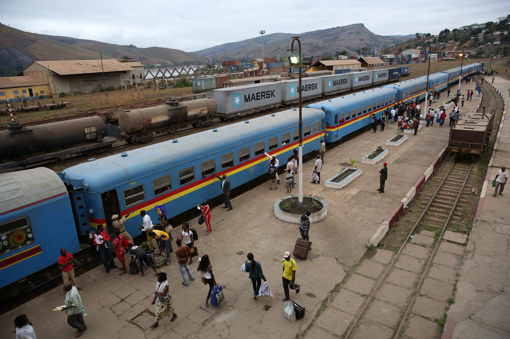

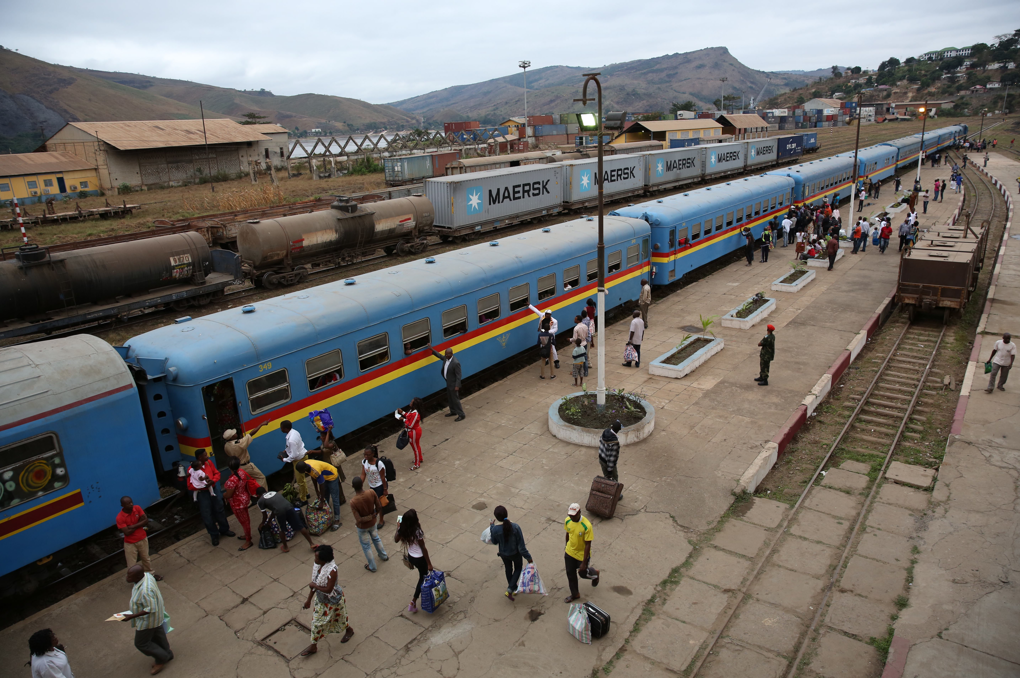

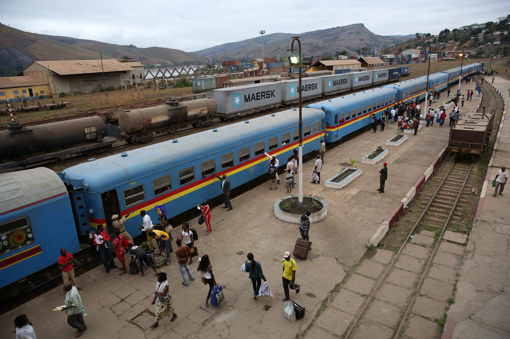

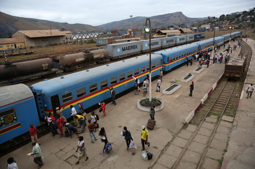

In [15]:
import random
from IPython.display import display

split = "valid"
hr_dir = HR_VALID if split == "valid" else HR_TRAIN
hr_imgs = image_list(hr_dir)
random.seed(0)
hr_path = random.choice(hr_imgs)

im_hr = Image.open(hr_path).convert("RGB")
im_x2 = Image.open(lr_dir(2, split) / hr_path.name).convert("RGB")
im_x4 = Image.open(lr_dir(4, split) / hr_path.name).convert("RGB")
im_x8 = Image.open(lr_dir(8, split) / hr_path.name).convert("RGB")

print("Picked:", hr_path.name)
print("HR:", im_hr.size, " | X2:", im_x2.size, " | X4:", im_x4.size, " | X8:", im_x8.size)
display(im_hr.resize((im_hr.size[0]//4, im_hr.size[1]//4)))  # shrink for notebook view
display(im_x2)
display(im_x4)
display(im_x8)


### Import PyTorch and Set Helpers

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from pathlib import Path

def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    """
    WHAT: Convert a PIL image (H x W x 3, uint8) to a float tensor in [0,1] shaped (3, H, W).
    WHY: PyTorch models expect CHW tensors, not PIL images.
    """
    t = TF.to_tensor(img)  # scales to [0,1], returns float32 CHW
    return t


Minimal dataset for aligned LR/HR pairs

What this does:

You choose a split ("train" or "valid") and a scale (2, 4, or 8).

It finds all HR files, then loads the matching LR file with the same filename from LR_bicubic/X{scale}/{split}.

It returns a dict with lr, hr, filename, and scale.

In [24]:
# Define class
class DIV2KDataset(Dataset):
    """
    WHAT: Paired dataset that yields {"lr": tensor, "hr": tensor, "filename": str, "scale": int}
    WHY: Training needs perfectly aligned LR-HR pairs for stable learning.
    """
    # Define data paths
    def __init__(self, data_root: Path, split: str="train", scale: int=4, patch_size: int | None = None):
        # Validate inputs
        assert split in {"train", "valid"}, "split must be 'train' or 'valid'"
        assert scale in {2, 4, 8}, "scale must be one of 2, 4, or 8"

        # Store parameters
        self.data_root = Path(data_root)
        self.split = split
        self.scale = scale
        self.patch_size = patch_size # HR patch size

        # Directories
        self.hr_dir = (self.data_root / "HR" / split)
        self.lr_dir = (self.data_root / "LR_bicubic" / f"X{scale}" / split)

        # List all HR images and keep only those that have a matching LR
        exts = {".png", ".jpg", ".jpeg"}
        hr_paths = sorted([p for p in self.hr_dir.iterdir() if p.suffix.lower() in exts])

        # Keep only items with matching LR images
        self.items = []
        for hrp in hr_paths:
            lrp = self.lr_dir / hrp.name
            if lrp.exists():
                self.items.append((lrp, hrp))
            else:
                print(f"Warning: Missing LR image for {hrp.name}, skipping.")
                pass
        
        if len(self.items) == 0:
            raise RuntimeError(f"No paired items found for split={split}, scale=X{scale}.\
                               \nCheck folders: {self.lr_dir} and {self.hr_dir}")

    # Dataset length
    def __len__(self):
        return len(self.items)

    # Aligned random crop helper
    def _aligned_random_crop(self, lr_img: Image.Image, hr_img: Image.Image, ps: int):
        """
        Crop an HR patch of size (ps x ps) at a random location,
        and the matching LR patch at (ps/scale x ps/scale).
        """
        assert ps % self.scale == 0, f"patch_size ({ps}) must be divisible by scale ({self.scale})"
        lr_ps = ps // self.scale

        # Random top-left in HR space
        max_x = hr_img.width  - ps
        max_y = hr_img.height - ps
        if max_x < 0 or max_y < 0:
            raise ValueError(f"HR image smaller than patch_size={ps}: got {(hr_img.width, hr_img.height)}")

        # Choose coordinates (0 allowed so +1 only if max>0)
        x = 0 if max_x == 0 else torch.randint(0, max_x + 1, (1,)).item()
        y = 0 if max_y == 0 else torch.randint(0, max_y + 1, (1,)).item()

        # HR crop
        hr_crop = hr_img.crop((x, y, x + ps, y + ps))

        # Corresponding LR coords (scaled down)
        lr_x, lr_y = x // self.scale, y // self.scale
        lr_crop = lr_img.crop((lr_x, lr_y, lr_x + lr_ps, lr_y + lr_ps))

        return lr_crop, hr_crop

    # Convert images to tensors
    def __getitem__(self, idx: int):
        lrp, hrp = self.items[idx]

        # Load as PIL
        lr_img = Image.open(lrp).convert("RGB")
        hr_img = Image.open(hrp).convert("RGB")

        # Aligned crop
        if self.patch_size is not None:
            lr_img, hr_img = self._aligned_random_crop(lr_img, hr_img, self.patch_size)

        # To tensors
        lr = pil_to_tensor(lr_img)  # (3, h, w), [0,1]
        hr = pil_to_tensor(hr_img)  # (3, H, W), [0,1]

        return {
            "lr": lr,
            "hr": hr,
            "filename": hrp.name,
            "scale": self.scale,
        }
    



Quick smoke test to validate shapes, scale relationship, and filenames

In [27]:
# X4 sanity check
ds_valid_x4 = DIV2KDataset(data_root=DATA_ROOT, split="valid", scale=4)
print("Pairs in valid X4:", len(ds_valid_x4))

sample = ds_valid_x4[0]
print("filename:", sample["filename"])
print("scale:", sample["scale"])
print("LR shape:", tuple(sample["lr"].shape))   # (3, h, w)
print("HR shape:", tuple(sample["hr"].shape))   # (3, H, W)

# double-check the scale relationship numerically (H == h*scale, W == w*scale)
_, h, w = sample["lr"].shape
_, H, W = sample["hr"].shape
print("H == h*scale ? ", H == h * sample["scale"], "(", H, "==", h, "*", sample["scale"], ")")
print("W == w*scale ? ", W == w * sample["scale"], "(", W, "==", w, "*", sample["scale"], ")")

Pairs in valid X4: 100
filename: 0801.png
scale: 4
LR shape: (3, 339, 510)
HR shape: (3, 1356, 2040)
H == h*scale ?  True ( 1356 == 339 * 4 )
W == w*scale ?  True ( 2040 == 510 * 4 )


In [28]:
# DataLoader smoke test
loader = DataLoader(ds_valid_x4, batch_size=2, shuffle=False, num_workers=0) # num_workers=0 keeps it simple; we can tune later.

batch = next(iter(loader))
print("Batch keys:", list(batch.keys()))
print("LR batch:", tuple(batch["lr"].shape))  # (B, 3, h, w)
print("HR batch:", tuple(batch["hr"].shape))  # (B, 3, H, W)
print("filenames:", batch["filename"])
print("scales:", batch["scale"])

Batch keys: ['lr', 'hr', 'filename', 'scale']
LR batch: (2, 3, 339, 510)
HR batch: (2, 3, 1356, 2040)
filenames: ['0801.png', '0802.png']
scales: tensor([4, 4])


In [29]:
# Patch extraction test
ds = DIV2KDataset(DATA_ROOT, split="train", scale=4, patch_size=128)
s = ds[0]
print("HR patch:", s["hr"].shape)  # (3, 128, 128)
print("LR patch:", s["lr"].shape)  # (3, 32, 32)

HR patch: torch.Size([3, 128, 128])
LR patch: torch.Size([3, 32, 32])
